# Heatmap Generation

Use model to inference a new map

<img src="assets/GoodEnoughDNM.png" width="640"/>


In [33]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")

# Specify Model to test

In [34]:
simple = False
epochs = 6
ipx = True 
dropout = .5
batch_size = 128
# bc_resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
#model_name = "bc_resnet18_simple_NOIPEX_6Epochs_gold"
#resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
#ON_resnet18_simpleFalse_IPEXTrue_Epochs6_dropout0.5_batch128
model_name = f"ON_resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
print(model_name)
model_read = torch.jit.load(f"models/{model_name}.pt")
model_read.eval()

ON_resnet18_simpleFalse_IPEXTrue_Epochs6_dropout0.5_batch128


RecursiveScriptModule(
  original_name=DinosourBoneFinder
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_nam

# Define functions and normalization parameters

In [35]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    paths = []
    for (imgs, _, fpaths) in dataloader:
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
    return images, yhats, paths

def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=4, figsize=(10, 6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))

def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean

# Prepare final test set

In [36]:
# !mkdir data/ThreeClassManualRemove0s/test
# !mkdir  data/ThreeClassManualRemove0s/test/unknown
# !cp data/DinosaurNationalMonument/20220514/224/*.jpg data/ThreeClassManualRemove0s/test/unknown/

# Load data

infered images with labels


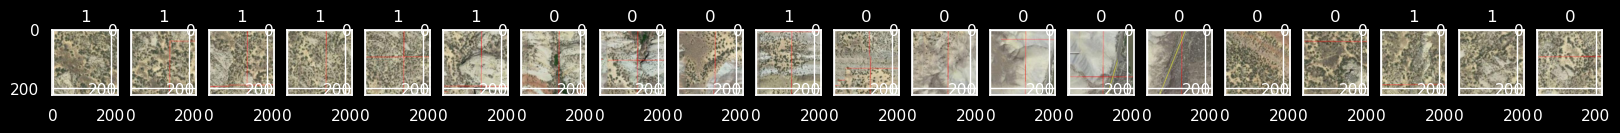

In [37]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
images, yhats, img_paths = infer(
    model_read, data_path="./data/ThreeClassManualRemove0s/test/"
)
infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=100, shuffle=False)
print("infered images with labels")
show_data(infer_dataloader, imagenet_stats, 20, figsize=(20, 16))


# Inference Given Large Image

In [38]:
import glob
from PIL import Image
from os.path import exists
import os
path = "data/DinosaurNationalMonument/m_4010938_ne_12_060_20211004_bc_cropped2.png"
#path = "data/Explore/Pombal01.PNG"

img = Image.open(path).convert('RGB')
img.size

(5869, 2895)

# Get sample near DNM Excavation

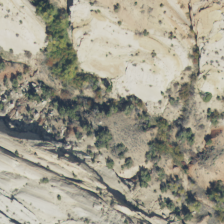

In [39]:
left = 4*224+270
low = 4*224+233

bbox = (left, low, left + 224, low + 224)
working_slice = img.crop(bbox)
working_slice

# Simple eval function

In [40]:
from PIL import Image
import torchvision.transforms.functional as TF
import time

def transform_image(image):
    my_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    return my_transforms(image).unsqueeze(0)

def eval_simple(working_slice):
    x = transform_image(working_slice)
    output = model_read(x)
    return output.detach().numpy().argmax()
st = time.time()
eval_simple(working_slice)
print( time.time() -st)

0.03571486473083496


In [41]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=16,
    )
    yhats = []
    images = []
    paths = []
    
    infer_time_sum = 0
    start_time = time.perf_counter()
    for (imgs, _, fpaths) in dataloader:
        start = time.perf_counter()
        yhat = model(imgs)
        end = time.perf_counter()
        time_torch = end - start
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
        infer_time_sum += time_torch
    end_time = time.perf_counter()    
    print(
        f"PyTorch model on CPU with batch inference: {infer_time_sum} total time, "
    )
    print("Overall running time elapsed for PyTorch format batch inference: ", end_time - start_time)
    return images, yhats, paths

In [42]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
images, yhats, img_paths = infer(
    model_read, data_path="./data/DinosaurNationalMonument/geemap"
)

PyTorch model on CPU with batch inference: 3.900567475706339 total time, 
Overall running time elapsed for PyTorch format batch inference:  6.496336154639721


# Score large map of DNM

<img src="data/DinosaurNationalMonument/Dinosaur National Monument Panorama.png" width="500"/>


# Read large image and score it

In [43]:
import glob
from PIL import Image
from os.path import exists
import os

img = Image.open(path).convert('RGB')

import time

from PIL import Image
countBuf = np.ones( (img.size[0], img.size[1]) )
sumBuf   = np.zeros( (img.size[0], img.size[1]) )

start = time.time()
step = 32  # choose a factor of 224: 1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112, and 224. Small is smooth map, large is fast
counts = {0:0, 1:0, 2:0}
scale = {0:1, 1:0, 2:0}  # score dictinary mapping raw score to weight to be used, Morrison = 0
for x in tqdm(range(0, img.size[0]-224, step)):
    for y in range(0, img.size[1]-224, step):  
        bbox = (x, y, x + 224, y + 224)
        working_slice = img.crop(bbox)
        countBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += 1
        sumBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += scale[eval_simple(working_slice)]
print(f"step size = {step}, Elapsed: {(time.time() - start):6.1f} sec")


100%|██████████| 177/177 [02:24<00:00,  1.22it/s]

step size = 32, Elapsed:  144.9 sec


In [74]:
bob   = np.zeros( (img.size[0], img.size[1]) )
scale[eval_simple(working_slice)]
bob[bbox[0]:bbox[2], bbox[1]:bbox[3]] = 1
bob[bob == 1].reshape(-1,224)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

# Numba

In [44]:
# import glob
# from PIL import Image
# from os.path import exists
# import os
# import dask

# img = Image.open(path).convert('RGB')

# import time

# from PIL import Image
# countBuf = np.ones( (img.size[0], img.size[1]) )
# sumBuf   = np.zeros( (img.size[0], img.size[1]) )

# def kernel(sumBufpatch, working_slice):
#     sumBufpatch = scale[eval_simple(working_slice)]
#     return sumBufpatch
    
# start = time.time()
# step = 32  # choose a factor of 224: 1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112, and 224. Small is smooth map, large is fast
# counts = {0:0, 1:0, 2:0}
# scale = {0:1, 1:0, 2:0}  # score dictinary mapping raw score to weight to be used, Morrison = 0
# for x in tqdm(range(0, img.size[0]-224, step)):
#     for y in range(0, img.size[1]-224, step):  
#         bbox = (x, y, x + 224, y + 224)
#         working_slice = img.crop(bbox)
#         countBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += 1
#         dask.delayed(kernel)(sumBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]], working_slice)     
#         #sumBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += scale[eval_simple(working_slice)]
# print(f"step size = {step}, Elapsed: {(time.time() - start):6.1f} sec")
# dask.compute(*sumBuf)


In [45]:
# %%time
# S = np.zeros( (img.size[0], img.size[1]) )
# for i in range(len(sumBuf)):
#     S += sumBuf[i]
# S

In [46]:
# sumBuf

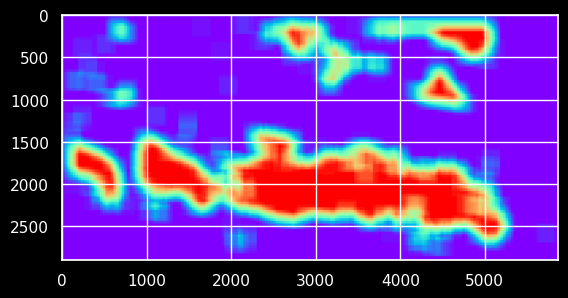

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(sumBuf.T, cmap='rainbow', interpolation='bilinear')
plt.show()

# Compute the mean of scores for sliding tiles

In [48]:
#set opacity to 159: 0 is transparent, 255 is opaque
meanBuf = sumBuf/countBuf
mat = np.uint8(meanBuf.T*159/meanBuf.max()) # scale the opacity: 0 transpartent, 255 solid
idx = mat < 0
mat[idx] = 0
output = Image.fromarray(mat)
output.save('results/bobTile.png')
np.save('results/meanBuf.npy', mat)

# Heatmap Approach

Color Legend:
- Bright Red: Bones more likely
- Bright Blue: Bone not likely

In [49]:
# from PIL import ImageDraw
# import numpy as np

# img = Image.open(path)
# alpha = np.load('results/meanBuf.npy')

# imgcv = Image.open(path.replace('.jpg','.PNG'))
# heatmap_img = np.copy(imgcv)
# alpha1D = alpha/alpha.max()*255

# heatmap_img[:,:,0] = alpha1D
# heatmap_img[:,:,1] = 255 - alpha1D
# heatmap_img[:,:,2] = 255 - alpha1D

# opacity = .5
# imgHeat = Image.blend(Image.fromarray(heatmap_img), imgcv, alpha=0.5)
# imgHeat.save('results/HeatMap.png')
# print(model_name)
# print("Color Legend:\n- Red: Higher Probability\n- Blue: -Lower Probability")
# #imgHeat


In [50]:
sumBuf.min()

0.0

In [51]:
# #https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
# from matplotlib.image import NonUniformImage
# import matplotlib.pyplot as plt

# print(sumBuf.shape)

# H, yedges, xedges = np.histogram2d(sumBuf.reshape(2,-1)[0], sumBuf.reshape(2,-1)[1])
# #H, yedges, xedges = np.histogram2d(x, y, bins=17)

# H.shape

In [52]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

# xedges = [0, 1, 3, 5]
# yedges = [0, 2, 3, 4, 6]

# x = np.random.normal(2, 1, 100)
# y = np.random.normal(1, 1, 100)
#H, xedges, yedges = np.histogram2d(x, y)
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
# H = H.T
# H.min()

In [53]:
# fig = plt.figure(figsize=(7, 3))
# ax = fig.add_subplot(131, title='imshow: square bins')
# plt.imshow(H, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [54]:
# ax = fig.add_subplot(132, title='pcolormesh: actual edges',
#         aspect='equal')
# X, Y = np.meshgrid(x, y)
# plt.pcolormesh(X, Y, H)
# plt.show()

In [55]:
# ax = fig.add_subplot(133, title='NonUniformImage: interpolated',
#         aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
# im = NonUniformImage(ax, interpolation='bilinear')
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# im.set_data(xcenters, ycenters, H)
# ax.add_image(im)
# plt.show()

In [56]:
# """
# ================
# Image nonuniform
# ================

# This illustrates the NonUniformImage class.  It is not
# available via an Axes method, but it is easily added to an
# Axes instance as shown here.
# """

# import matplotlib.pyplot as plt
# import numpy as np

# from matplotlib import cm
# from matplotlib.image import NonUniformImage

# interp = 'nearest'

# # Linear x array for cell centers:
# x = np.linspace(-4, 4, 9)

# #Highly nonlinear x array:
# x2 = x**3

# y = np.linspace(-4, 4, 9)

# z = np.sqrt(x[np.newaxis, :]**2 + y[:, np.newaxis]**2)

# fig, axs = plt.subplots(nrows=2, ncols=2)
# fig.suptitle('NonUniformImage class', fontsize='large')
# ax = axs[0, 0]
# im = NonUniformImage(ax, interpolation=interp, extent=(-4, 4, -4, 4),
#                      cmap=cm.Reds)
# im.set_data(x, y, z)
# ax.add_image(im)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
# ax.set_title(interp)

# ax = axs[0, 1]
# im = NonUniformImage(ax, interpolation=interp, extent=(-64, 64, -4, 4),
#                      cmap=cm.Reds)
# im.set_data(x2, y, z)
# ax.add_image(im)
# ax.set_xlim(-64, 64)
# ax.set_ylim(-4, 4)
# ax.set_title(interp)

# interp = 'bilinear'

# ax = axs[1, 0]
# im = NonUniformImage(ax, interpolation=interp, extent=(-4, 4, -4, 4),
#                      cmap=cm.Purples)
# im.set_data(x, y, z)
# ax.add_image(im)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
# ax.set_title(interp)

# ax = axs[1, 1]
# im = NonUniformImage(ax, interpolation=interp, extent=(-64, 64, -4, 4),
#                      cmap=cm.Reds)
# im.set_data(x2, y, z)
# ax.add_image(im)
# ax.set_xlim(-64, 64)
# ax.set_ylim(-4, 4)
# ax.set_title(interp)

# plt.show()


# Compare to ground truth:

-Trip Chesebrough Jensen UT 2018/03/10 DInosaur National Monument: fragments found plus one NC2, one LNC2

<img src="assets/ResultsDNMGoodEnough.JPG" width="1000"/>

<img src="assets/NGMDB_DNM.jpg" width="1000"/>

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 